In [1]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from yellowbrick.regressor import prediction_error, ResidualsPlot

In [7]:
# Load the DataFrame from the Excel file
file_path = 'STADS_removedActivityCliffs_ECFP42048.xlsx'
df = pd.read_excel(file_path)

In [8]:
# Define the columns you want to drop
columns_to_drop = {'chi4v', 'chi2v', 'NumUnspecifiedAtomStereoCenters', 'NumAliphaticHeterocycles', 
                   'NumRings', 'NumHeavyAtoms', 'NumHeteroatoms', 'lipinskiHBA', 'chi3v', 
                   'labuteASA', 'CrippenMR', 'chi0v', 'Phi', 'kappa1', 'NumSaturatedHeterocycles', 
                   'lipinskiHBAHBD', 'NumAtoms', 'Total Surface Area', 'chi1v', 'NumBridgeheadAtoms'}

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop, errors='ignore')

print(df.shape)
df.head(1)

(209, 25)


,NEW_SMILES,pIC50,amw,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,FractionCSP3,NumAromaticRings,...,NumAtomStereoCenters,tpsa,CrippenClogP,hallKierAlpha,kappa2,kappa3,Shape Index,Molecular Flexibility,Molecular Complexity,fp
0,CC(=O)N(C)Cc1cc(C(=O)N(C)Cc2cc3ccccc3n2C)ccc1N,5.173925,378.476,2,5,1,4,2,0.272727,3,...,0,71.57,3.011,-3.28,7.760914,3.856356,0.53571,0.608,0.81905,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
# Ensure 'NEW_SMILES' is retained
# df = df.drop(columns=['NEW_SMILES'])  # Do not drop this column

# Convert 'fp' column from string representations to numpy arrays
df['fp'] = df['fp'].apply(ast.literal_eval)

df['fp'] = df['fp'].apply(lambda x: np.array(x))

# Extract features and target variable
X = np.stack(df['fp'].values)
y = df['pIC50'].values

In [10]:
# Split the data into training and test sets, keeping track of indices
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=10001010)

# Define the SVR model with the best hyperparameters
model = SVR(C=3, epsilon=0.01, gamma='auto', kernel='rbf')

# Create a pipeline with StandardScaler and the tuned SVR model
pipeline = make_pipeline(StandardScaler(), model)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=3, epsilon=0.01, gamma='auto'))])

In [11]:
# Make predictions on the test set
predictions = pipeline.predict(X_test)
train_predictions = pipeline.predict(X_train)

# Calculate performance metrics
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(y_test, predictions)
spearman_train, _ =spearmanr(y_train, train_predictions)

# Print performance metrics and Spearman correlation
print(f"The mean absolute error: {mae}")
print(f"The root mean squared error: {rmse}")
print(f"Spearman correlation on test set: {spearman_corr}")
print(f"Spearman correlation on train set: {spearman_train}")

The mean absolute error: 0.37078696850457205
The root mean squared error: 0.4867654009754474
Spearman correlation on test set: 0.8912364216799865
Spearman correlation on train set: 0.9684689101542213


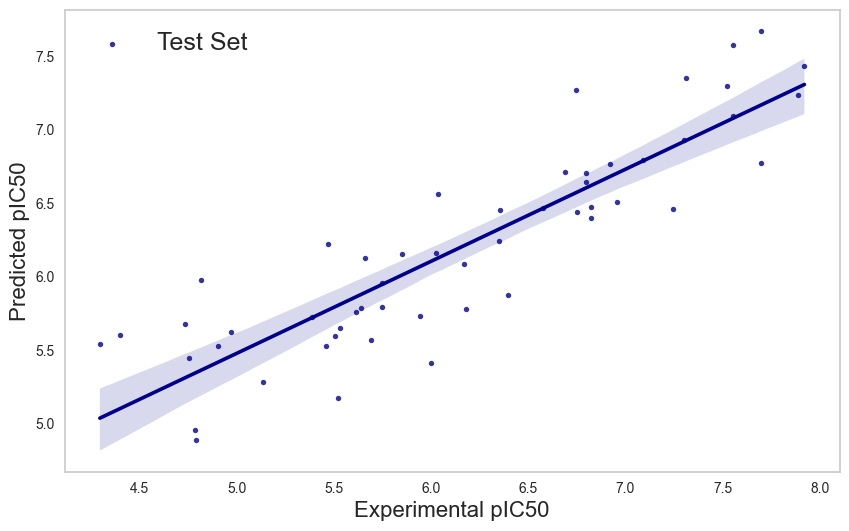

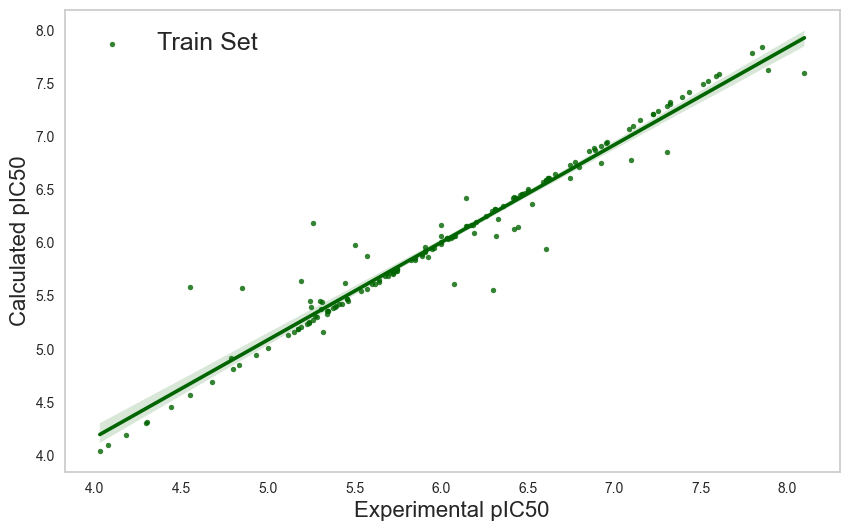

In [12]:
# Plot predictions vs actual for the test set
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=y_test, y=predictions, scatter_kws={'s': 15}, color='darkblue', label='Test Set')

# Add a diagonal line to show ideal predictions
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Set labels and title
ax.set_xlabel("Experimental pIC50", fontsize=16)  # Set x-axis label with font size
ax.set_ylabel("Predicted pIC50", fontsize=16)  # Set y-axis label with font size
ax.grid(False)
# Display the plot for the test set
plt.legend(fontsize=18)  # Increase legend font size
plt.show()

# Plot predictions vs actual for the training set
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=y_train, y=train_predictions, scatter_kws={'s': 15}, color='darkgreen', label='Train Set')

# Set labels and title
ax.set_xlabel("Experimental pIC50", fontsize=16)  # Set x-axis label with font size
ax.set_ylabel("Calculated pIC50", fontsize=16)  # Set y-axis label with font size

ax.grid(False)
# Display the plot for the training set
plt.legend(fontsize=18)   # Increase legend font size
plt.show()


**Spearman correlation (cross-validation)**

In [28]:
# Define a custom scoring function for Spearman correlation
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]  # Only return the correlation coefficient

# Create a scorer based on the custom Spearman function
spearman_scorer = make_scorer(spearman_corr, greater_is_better=True)

# Perform cross-validation with 5 folds using the Spearman correlation as the scoring metric
cv_scores_spearman = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=spearman_scorer)

# Print the cross-validation Spearman correlation scores
print(f"Cross-Validation Spearman Correlation Scores: {cv_scores_spearman}")
print(f"Mean Cross-Validation Spearman Correlation Score: {cv_scores_spearman.mean()}")

Cross-Validation Spearman Correlation Scores: [0.61484877 0.47383809 0.71980238 0.75846774 0.68373828]
Mean Cross-Validation Spearman Correlation Score: 0.6501390537700183


In [29]:
# Set up Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Use MSE as the scoring function for LOOCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform LOOCV using MSE as the scoring metric
loocv_scores = cross_val_score(pipeline, X, y, cv=loo, scoring=mse_scorer)

# Calculate the mean MSE score from LOOCV (note that cross_val_score returns negative MSE values)
mean_loocv_mse = -loocv_scores.mean()

# Output the LOOCV MSE scores and the mean MSE score
#print(f"LOOCV MSE scores: {loocv_scores}")
print(f"Mean LOOCV MSE score: {mean_loocv_mse}")

Mean LOOCV MSE score: 0.33395217506692065


### **Making prediction of new data on trained model**

In [24]:
# Prepare the dataset
new_file_path = 'file with compounds generated by transformation rules.txt'  # Replace with your actual file path
new_df = pd.read_csv(new_file_path)

In [25]:
# Define the columns you want to drop
columns_to_drop = {'chi4v', 'chi2v', 'NumUnspecifiedAtomStereoCenters', 'NumAliphaticHeterocycles', 
                   'NumRings', 'NumHeavyAtoms', 'NumHeteroatoms', 'lipinskiHBA', 'chi3v', 
                   'labuteASA', 'CrippenMR', 'chi0v', 'Phi', 'kappa1', 'NumSaturatedHeterocycles', 
                   'lipinskiHBAHBD', 'NumAtoms', 'Total Surface Area', 'chi1v', 'NumBridgeheadAtoms'}

# Drop the columns from the DataFrame
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')

print(df.shape)
new_df.head(1)

(209, 25)


,NEW_SMILES,Shape Index,Molecular Flexibility,Molecular Complexity,amw,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,...,NumHeterocycles,NumAromaticHeterocycles,NumSpiroAtoms,NumAtomStereoCenters,tpsa,CrippenClogP,hallKierAlpha,kappa2,kappa3,fp
0,Oc1ccc(C=C2CCc3c(n(Cc4ccc(O)cc4)c4ccccc34)C2)cc1,0.55172,0.33101,0.88694,381.475,2,3,2,3,0,...,1,1,0,0,45.39,5.6731,-3.46,7.173162,3.401712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
if 'fp' in new_df.columns:
    new_df['fp'] = new_df['fp'].apply(ast.literal_eval)
    new_df['fp'] = new_df['fp'].apply(lambda x: np.array(x))


In [27]:
# Step 3: Use the Trained Model to Make Predictions on the New Dataset
X_new = np.stack(new_df['fp'].values)
predictions_new = pipeline.predict(X_new)

In [28]:
#Assign Predicted pIC50 Values to Respective SMILES
new_df = new_df.copy()
new_df['Predicted_pIC50'] = predictions_new
print(new_df[['NEW_SMILES', 'Predicted_pIC50']].head())
print(len(new_df))

                                          NEW_SMILES  Predicted_pIC50
0   Oc1ccc(C=C2CCc3c(n(Cc4ccc(O)cc4)c4ccccc34)C2)cc1         6.000931
1  N=C(c1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3ccccc...         5.996163
2  O=C(Oc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         6.361566
3  O=C(Nc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         6.118492
4  O=C(Sc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         6.120699
172026


In [29]:
new_df.to_csv('Save your file.txt', index=False)


In [30]:
new_df.columns

Index(['NEW_SMILES', 'Shape Index', 'Molecular Flexibility',
       'Molecular Complexity', 'amw', 'lipinskiHBD', 'NumRotatableBonds',
       'NumHBD', 'NumHBA', 'NumAmideBonds', 'FractionCSP3', 'NumAromaticRings',
       'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles',
       'NumAromaticHeterocycles', 'NumSpiroAtoms', 'NumAtomStereoCenters',
       'tpsa', 'CrippenClogP', 'hallKierAlpha', 'kappa2', 'kappa3', 'fp',
       'Predicted_pIC50'],
      dtype='object')

In [31]:
# Analyze predicted pIC50 values
print(new_df['Predicted_pIC50'].describe())


count    172026.000000
mean          6.122594
std           0.304228
min           5.001199
25%           5.920470
50%           6.111332
75%           6.309068
max           7.668725
Name: Predicted_pIC50, dtype: float64
